In [1]:
import pandas as pd
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from textblob import TextBlob
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [44]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 280)

football_feed_df = pd.read_pickle('football_feed_df.pkl')
print(football_feed_df.columns)
football_feed_df.head()

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'metadata',
       'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status', 'retweet_count',
       'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive',
       'lang', 'team', 'user_id', 'retweeted_status_id', 'text', 'hashtags',
       'user_mentions', 'emoji', 'processed_text'],
      dtype='object')


,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,geo,coordinates,place,contributors,is_quote_status,quoted_status_id,quoted_status_id_str,quoted_status,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,lang,team,user_id,retweeted_status_id,text,hashtags,user_mentions,emoji,processed_text
0,Thu Nov 19 15:16:52 +0000 2020,1329443531694481411,1329443531694481411,"Thinking about how many Iowa meat packers voted for Bernie who would’ve given them ownership stake in their business, greater control over their conditions, and Medicare for All.",False,"[0, 202]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/wef0Do6kyu', 'expanded_url': 'https://twitter.com/dmregister/status/1329431739475832835', 'display_url': 'twitter.com/dmregister/sta…', 'indices': [179, 202]}], 'media': [{'id': 13294435273114...","{'media': [{'id': 1329443527311450121, 'id_str': '1329443527311450121', 'indices': [203, 226], 'media_url': 'http://pbs.twimg.com/media/EnMh2CpXYAkQrUs.jpg', 'media_url_https': 'https://pbs.twimg.com/media/EnMh2CpXYAkQrUs.jpg', 'url': 'https://t.co/xlo5NGg6iD', 'display_url':...","{'result_type': 'popular', 'iso_language_code': 'en'}","<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.329432e+18,1329431739475832835,"{'created_at': 'Thu Nov 19 14:30:00 +0000 2020', 'id': 1329431739475832835, 'id_str': '1329431739475832835', 'full_text': 'A lawsuit claims that the manager at Tyson's Waterloo plant a betting pool for supervisors and managers to wager how many plant employees would test posi...",321,2714,False,False,False,en,Packers,1332630685,NaN,NaN,[],,[],"Thinking many Iowa meat packer voted Bernie would ’ given ownership stake business , greater control condition , Medicare All ."
1,Thu Nov 19 21:19:15 +0000 2020,1329534730115702787,1329534730115702787,Packers' WR Davante Adams did not practice today due to an ankle injury.,False,"[0, 72]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}",NaN,"{'result_type': 'popular', 'iso_language_code': 'en'}","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,186,3846,False,False,NaN,en,Packers,51263592,NaN,NaN,[],,[],Packers ' WR Davante Adams practice today due ankle injury .
2,Thu Nov 19 17:22:17 +0000 2020,1329475092603146241,1329475092603146241,"Says Darius Leonard, on Packers QB Aaron Rodgers calling San Fran's Fred Warner ""the best linebacker in the game"" a few weeks ago:\n\n""I've been thinking about that ever since he said that. I hope I can change his mind.""\n\nPackers at Colts on Sunday 🍿",False,"[0, 248]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': []}",NaN,"{'result_type': 'popular', 'iso_language_code': 'en'}","<a href=""https://mobile.twitter.com"" rel=""nofollow"">Twitter Web App</a>",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,125,1421,False,False,NaN,en,Packers,37568810,NaN,NaN,[],,"[(🍿, :popcorn:)]","Says Darius Leonard , Packers QB Aaron Rodgers calling San Fran 's Fred Warner `` best linebacker game '' week ago : '' I 've thinking ever since said . I hope I change mind . '' Packers Colts Sunday 🍿"
3,Fri Nov 20 20:49:43 +0000 2020,1329889684009463809,1329889684009463809,Try Out Former And QB DeShone Kizer #Browns #chicagobears #packers #raiders #nfl,False,"[0, 120]","{'hashtags': [{'text': 'Browns', 'indices': [76, 83]}, {'text': 'chicagobears', 'indices': [84, 97]}, {'text': 'packers', 'indices': [98, 106]}, {'text': 'raiders', 'indices': [107, 115]}, {'text': 'nfl', 'indices': [116, 120]}], 'symbols': [], 'user_mentions': [{'screen_name...","{'media': [{'id': 1329889658545836036, 'id_str': '1329889658545836036', 'indices': [121, 144], 'media_url': 

In [3]:
#check to see how mnay repeat tweets we scraped. 

print(len(football_feed_df.full_text))
print(len(set(football_feed_df.full_text)))

6000
4160


In [33]:
#drop duplicate tweets 
football_feed_df.drop_duplicates(subset=['full_text'], inplace=True)
football_feed_df['team']= football_feed_df['team'].str.replace('DaBears', 'Bears')
football_feed_df['team'] = football_feed_df['team'].str.replace('ChiefsKingdom', 'Chiefs')

In [34]:
#check to make sure the number of tweets per team remains similar 
football_feed_df['team'].value_counts()

Cowboys    835
Eagles     745
Raiders    716
Packers    710
Bears      670
Chiefs     484
Name: team, dtype: int64

In [6]:
#shuffle the data 
np.random.seed(1)
df = football_feed_df.reindex(np.random.permutation(football_feed_df.index))

In [10]:
import re
contraction_patterns=[(r'can\'t', 'cannot'),
                    (r'haven\'t', 'have not'),
                    (r'(\w+)\'ll', '\g<1> will'),
                    (r'(\w+)\'re', '\g<1> are'),
                     (r'(\w+)\'ve', '\g<1> have'), 
                     (r'don\'t', 'do not')]

class contraction_replacer(object):
    def __init__(self, contraction_patterns):        
        # store compiled regex object
        self._contraction_regexes = [(re.compile(p), replaced_text) for p, replaced_text in contraction_patterns]
        
    def do_contraction_normalization(self, text):
        for contraction_regex, replaced_text in self._contraction_regexes:
            text = contraction_regex.sub(replaced_text, text)
        return text     
contraction_replacer = contraction_replacer(contraction_patterns)

In [11]:
def clean_tweet(tweet):
    btweet = contraction_replacer.do_contraction_normalization(tweet)
    wnetl = WordNetLemmatizer()
    ctweet = wnetl.lemmatize(btweet)
    word_regex= nltk.RegexpTokenizer(pattern=r'\w+', gaps=False)
    clean_tweet = word_regex.tokenize(ctweet)
    stopwords = nltk.corpus.stopwords.words('english')
    stop_clean_sent = [w for w in clean_tweet if w not in stopwords]
    return stop_clean_sent

In [12]:
clean_football_tweets = football_feed_df["full_text"].apply(clean_tweet)
football_feed_df['tokens'] = football_feed_df["full_text"].apply(clean_tweet)

clean_football_tweets[0:3]

0                                                                        [Thinking, many, Iowa, meat, packers, voted, Bernie, would, given, ownership, stake, business, greater, control, conditions, Medicare, All]
1                                                                                                                                                 [Packers, WR, Davante, Adams, practice, today, due, ankle, injury]
2       [Says, Darius, Leonard, Packers, QB, Aaron, Rodgers, calling, San, Fran, Fred, Warner, best, linebacker, game, weeks, ago, I, thinking, ever, since, said, I, hope, I, change, mind, Packers, Colts, Sunday]
3                                                                                                                           [Try, Out, Former, And, QB, DeShone, Kizer, Browns, chicagobears, packers, raiders, nfl]
4                                [Packers, QB, Jordan, Love, moved, Superstar, level, finishing, season, 4, 722, passing, yards, 47, tds, 29, ints, 

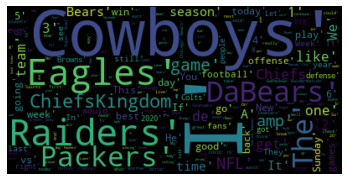

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

unique_string=(" ").join(map(str, clean_football_tweets))
wordcloud = WordCloud().generate(unique_string)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


plt.show()

Packers


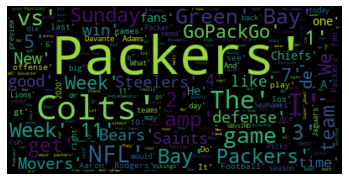

DaBears


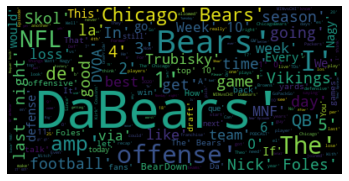

Eagles


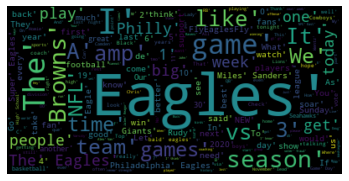

Cowboys


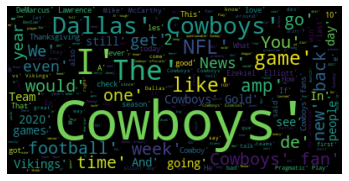

Raiders


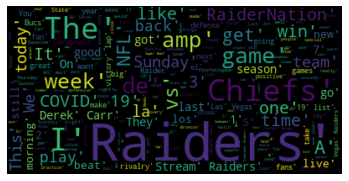

ChiefsKingdom


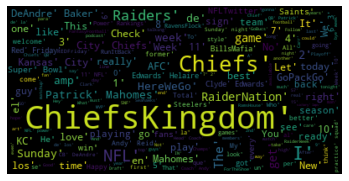

In [14]:
teams = ["Packers","Bears","Eagles", "Cowboys","Raiders", "Chiefs"]

for i in range(len(teams)):
    df = football_feed_df[football_feed_df['team']==teams[i]]
    print(teams[i])
    unique_string=(" ").join(map(str, df.tokens))
    wordcloud = WordCloud().generate(unique_string)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")


    plt.show()

# Some Legit Ass NLP

In [15]:
from nltk.corpus import twitter_samples

def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens) 
        
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

In [16]:
clean_positive = pd.Series(positive_tweets).apply(clean_tweet)
clean_negative = pd.Series(negative_tweets).apply(clean_tweet)

clean_positive = get_tweets_for_model(clean_positive)
clean_negative = get_tweets_for_model(clean_negative)


In [17]:
positive_dataset = [(tweet_dict, 1)
                     for tweet_dict in clean_positive]

negative_dataset = [(tweet_dict, 0)
                     for tweet_dict in clean_negative]

dataset = positive_dataset + negative_dataset
random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]


[({'rip': True, 'whitney': True, 'houston': True}, 0), ({'torrentialrain': True, 'today': True}, 0), ({'DEPORSEMPRE1': True, 'hello': True, 'info': True, 'possible': True, 'interest': True, 'Jonathas': True, 'He': True, 'close': True, 'join': True, 'Betis': True, 'saludos': True}, 0), ({'give': True, 'chance': True, 'daw': True}, 0), ({'AshrafUzma': True, 'RTAluvedAfridi': True, 'We': True, 'true': True, 'Pakistanis': True, 'p': True}, 1), ({'Hi': True, 'everyone': True, 'Good': True, 'afteNoon': True, 'feeling': True, 'Booooore': True}, 0), ({'GorobaoElisha': True, 'Imy': True}, 0), ({'Hi': True, 'BAM': True, 'BarsAndMelody': True, 'Can': True, 'follow': True, 'bestfriend': True, '969Horan696': True, 'She': True, 'loves': True, 'lot': True, 'See': True, 'Warsaw': True, 'lt': True, '3': True, 'Love': True, 'x46': True}, 1), ({'heartissoJEDlag': True, 'kwento': True, 'fbc': True}, 0), ({'QFYvonne': True, 'chipobangach': True, 'fellow': True, 'woman': True, 'proud': True, 'moment': True,

In [41]:

from nltk import classify
from nltk import NaiveBayesClassifier
classifier = nltk.NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))

#print(classifier.show_most_informative_features(10))


Accuracy is: 0.772


In [19]:
football_clean = get_tweets_for_model(clean_football_tweets)

football_dat = [(tweet_dict)
                     for tweet_dict in football_clean]
football_dat

[{'Thinking': True,
  'many': True,
  'Iowa': True,
  'meat': True,
  'packers': True,
  'voted': True,
  'Bernie': True,
  'would': True,
  'given': True,
  'ownership': True,
  'stake': True,
  'business': True,
  'greater': True,
  'control': True,
  'conditions': True,
  'Medicare': True,
  'All': True},
 {'Packers': True,
  'WR': True,
  'Davante': True,
  'Adams': True,
  'practice': True,
  'today': True,
  'due': True,
  'ankle': True,
  'injury': True},
 {'Says': True,
  'Darius': True,
  'Leonard': True,
  'Packers': True,
  'QB': True,
  'Aaron': True,
  'Rodgers': True,
  'calling': True,
  'San': True,
  'Fran': True,
  'Fred': True,
  'Warner': True,
  'best': True,
  'linebacker': True,
  'game': True,
  'weeks': True,
  'ago': True,
  'I': True,
  'thinking': True,
  'ever': True,
  'since': True,
  'said': True,
  'hope': True,
  'change': True,
  'mind': True,
  'Colts': True,
  'Sunday': True},
 {'Try': True,
  'Out': True,
  'Former': True,
  'And': True,
  'QB': Tr

In [20]:
classifier.classify(football_dat[0])

#Classify each tweet one by one (not a vectorized process)
sentiment = []
for tweet in football_dat:
    s = classifier.classify(tweet)
    sentiment.append(s)

football_feed_df['sentiment'] = sentiment

In [21]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

football_feed_df[['full_text', 'sentiment']]



,full_text,sentiment
0,"Thinking about how many Iowa meat packers voted for Bernie who would’ve given them ownership stake in their business, greater control over their conditions, and Medicare for All.",1
1,Packers' WR Davante Adams did not practice today due to an ankle injury.,0
2,"Says Darius Leonard, on Packers QB Aaron Rodgers calling San Fran's Fred Warner ""the best linebacker in the game"" a few weeks ago:\n\n""I've been thinking about that ever since he said that. I hope I can change his mind.""\n\nPackers at Colts on Sunday 🍿",0
3,Try Out Former And QB DeShone Kizer #Browns #chicagobears #packers #raiders #nfl,1
4,"Packers QB Jordan Love moved up to the Superstar level after finishing his season with 4,722 passing yards, 47 tds and 29 ints with a 111.8 passed rating and 66% completion rate. #Packers #GoPackGo",0
...,...,...
5984,"Every time the media talks about this dumb ass bus story, retweet this shit and ask the why they boo’d unit…",1
5986,Los planes de #ChiefsKingdom \n\n#NFLxESPN \n\n,0
5989,I’m so heated I feel like going all out with #ChiefsKingdom fuckin punks come get it let’s argue,1
5990,LETS GOOOOOOOOO!!!!!!,0


## read in journalism scrape

In [45]:
football_articles = pd.read_csv('sports_journalism.csv') #row 15 has text NAN
football_articles.isna().sum()

football_articles.dropna(subset=['Text'], inplace=True)
football_articles.isna().sum()#make sure there are no nans in txt or team 

football_articles['Team'].value_counts() #make sure team counts roughly even 

chiefs     117
bears      105
packers    100
eagles      95
cowboys     87
raiders     59
Name: Team, dtype: int64

In [46]:
#preprocess article text
article_tokens = football_articles["Text"].apply(clean_tweet)
clean_article = get_tweets_for_model(article_tokens)

article_dat = [(art_dict)
                     for art_dict in clean_article]
#article_dat[0:3]

[{'Chiefs': True,
  'coach': True,
  'Andy': True,
  'Reid': True,
  'addresses': True,
  'Raiders': True,
  'victory': True,
  'lap': True,
  'around': True,
  'Arrowhead': True,
  'last': True,
  'meeting': True,
  '0': True,
  '57': True,
  'HENDERSON': True,
  'Nev': True,
  'Jon': True,
  'Gruden': True,
  'post': True,
  'media': True,
  'conference': True,
  'Las': True,
  'Vegas': True,
  'defeated': True,
  'Denver': True,
  'Broncos': True,
  'Sunday': True,
  '75': True,
  'seconds': True,
  'old': True,
  'put': True,
  'damper': True,
  'things': True,
  'Picture': True,
  'downtrodden': True,
  'Chucky': True,
  'frown': True,
  'wet': True,
  'blanket': True,
  'rather': True,
  'maniacal': True,
  'grin': True,
  'blade': True,
  'Well': True,
  'satisfying': True,
  'said': True,
  'dropping': True,
  '37': True,
  'points': True,
  'picking': True,
  'four': True,
  'passes': True,
  'racking': True,
  'two': True,
  'sacks': True,
  'forcing': True,
  'fumble': True,

In [24]:
classifier.classify(article_dat[0])

sentiment = []
for a in article_dat:
    s = classifier.classify(a)
    sentiment.append(s)

football_articles['sentiment'] = sentiment

In [25]:
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 50)

football_articles[['Text', 'sentiment']]

,Text,sentiment
0,Chiefs coach Andy Reid addresses the Raiders' ...,1
1,Patrick Mahomes is announced as a member of th...,1
2,Chicago native Michael Wilbon says Theo Epstei...,1
3,"GREEN BAY, Wis. -- It's not Marquez Valdes-Sca...",0
4,"FRISCO, Texas -- As the country experiences a ...",1
...,...,...
559,Just as we thought the Kansas City Chiefs were...,1
560,Tucker D. FranklinWhile there are many Kansas ...,1
561,Chiefs Chairman and CEO Clark Hunt's decision ...,1
562,TNS. FNLWatch!! Eifel Grand Prix Live Online: ...,1


In [43]:
##combine the sources 
football_feed_df['source'] = ['Twitter' for r in range(len(football_feed_df))]
football_articles['source'] = ['Web Article' for r in range(len(football_articles))]

football_articles.rename(columns={'Team': 'team', 'Text': 'full_text'}, inplace=True)
football_articles['team'] = football_articles['team'].str.capitalize()
total_df = pd.concat([football_feed_df[['full_text', 'team', 'source', 'sentiment']], football_articles[['full_text', 'team', 'source', 'sentiment']]])

print(total_df['team'].value_counts())

total_df

Cowboys    922
Eagles     840
Packers    810
Raiders    775
Bears      775
Chiefs     601
Name: team, dtype: int64


,full_text,team,source,sentiment
0,Thinking about how many Iowa meat packers vote...,Packers,Twitter,1
1,Packers' WR Davante Adams did not practice tod...,Packers,Twitter,0
2,"Says Darius Leonard, on Packers QB Aaron Rodge...",Packers,Twitter,0
3,Try Out Former And QB DeShone Kizer #Browns #c...,Packers,Twitter,1
4,Packers QB Jordan Love moved up to the Superst...,Packers,Twitter,0
...,...,...,...,...
559,Just as we thought the Kansas City Chiefs were...,Chiefs,Web Article,1
560,Tucker D. FranklinWhile there are many Kansas ...,Chiefs,Web Article,1
561,Chiefs Chairman and CEO Clark Hunt's decision ...,Chiefs,Web Article,1
562,TNS. FNLWatch!! Eifel Grand Prix Live Online: ...,Chiefs,Web Article,1


team
Bears      0.575484
Chiefs     0.622296
Cowboys    0.506508
Eagles     0.566667
Packers    0.574074
Raiders    0.603871
Name: sentiment, dtype: float64

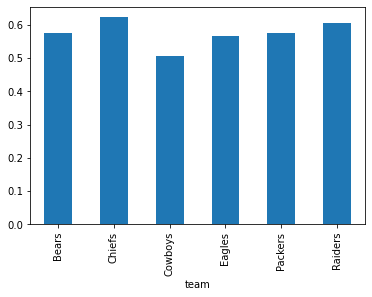

In [36]:
#group by teams
total_df.groupby('team')['sentiment'].mean().plot.bar()
total_df.groupby('team')['sentiment'].mean()

In [37]:
total_df.groupby(['team', 'source'])['sentiment'].mean()

team     source     
Bears    Twitter        0.558209
         Web Article    0.685714
Chiefs   Twitter        0.574380
         Web Article    0.820513
Cowboys  Twitter        0.480240
         Web Article    0.758621
Eagles   Twitter        0.548993
         Web Article    0.705263
Packers  Twitter        0.547887
         Web Article    0.760000
Raiders  Twitter        0.596369
         Web Article    0.694915
Name: sentiment, dtype: float64